# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   str         1206 non-null   int64 
 1   con         1206 non-null   int64 
 2   dex         1206 non-null   int64 
 3   cha         1206 non-null   int64 
 4   ac          1206 non-null   int64 
 5   level       1206 non-null   int64 
 6   perception  1206 non-null   int64 
 7   book        1206 non-null   object
 8   int         1206 non-null   int64 
 9   reflex      1206 non-null   int64 
 10  wis         1206 non-null   int64 
 11  focus       1206 non-null   int32 
 12  hp          1206 non-null   int64 
 13  will        1206 non-null   int64 
 14  fortitude   1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,str,con,dex,cha,ac,level,perception,book,int,reflex,wis,focus,hp,will,fortitude
0,7,5,2,1,29,10,20,Pathfinder Bestiary,1,19,2,1,215,17,22
1,9,5,0,1,28,10,16,Pathfinder Bestiary,-4,14,2,0,220,16,21
2,7,6,3,-2,25,8,17,Pathfinder Bestiary,-4,17,3,0,175,15,20
3,7,5,4,6,41,17,30,Pathfinder Bestiary,6,29,5,1,315,32,30
4,-5,1,3,1,16,1,6,Pathfinder Bestiary,-1,10,1,1,20,4,6


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


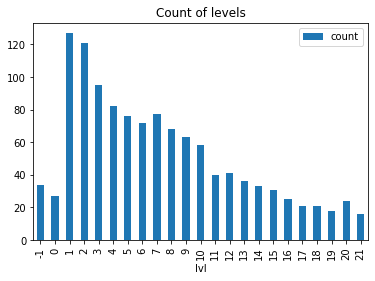

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

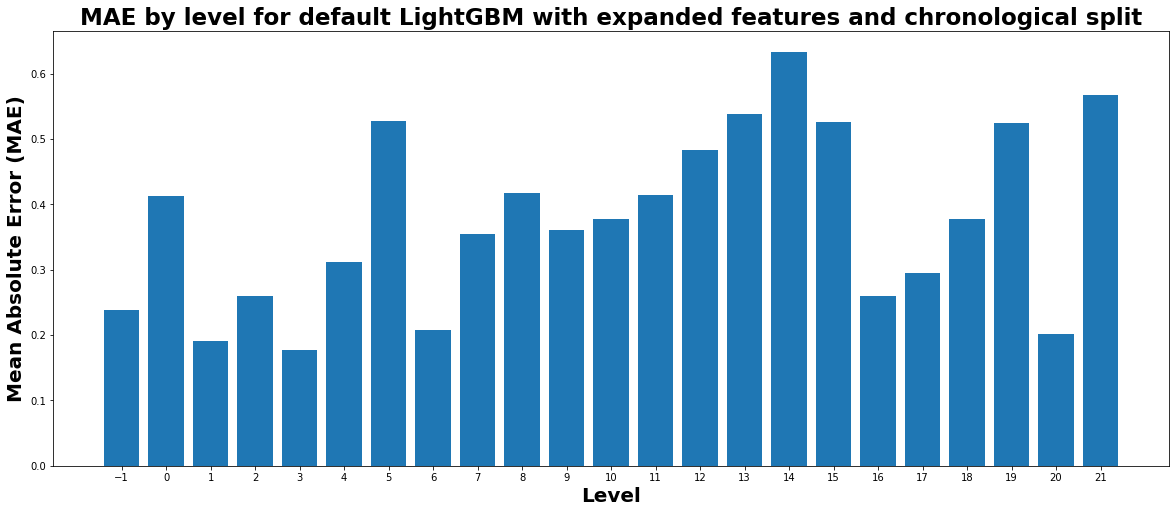

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.51

Round type: 0.5
RMSE: 0.55

Round type: 0.33
RMSE: 0.54

Round type: 0.45
RMSE: 0.54



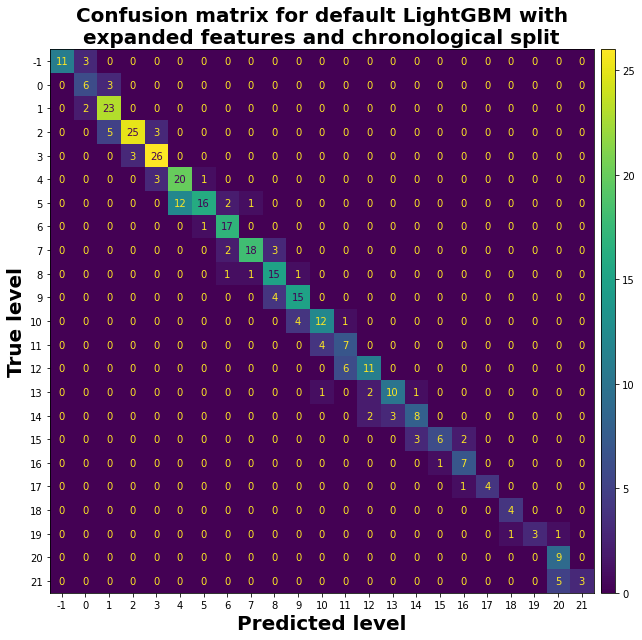

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nexpanded features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 13:19:30,929] A new study created in memory with name: no-name-cac77a6d-31be-482c-8aca-56f373eb7d6f
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


feature_fraction, val_score: 0.161265:  14%|######4                                      | 1/7 [00:01<00:10,  1.78s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.169031 + 0.0260212
[200]	cv_agg's l2: 0.167146 + 0.0241891


feature_fraction, val_score: 0.161265:  29%|############8                                | 2/7 [00:03<00:09,  1.85s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.171633 + 0.0331603
[200]	cv_agg's l2: 0.168406 + 0.0317806


feature_fraction, val_score: 0.161265:  43%|###################2                         | 3/7 [00:05<00:07,  1.99s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.176759 + 0.0298587
[200]	cv_agg's l2: 0.172932 + 0.0282762


feature_fraction, val_score: 0.161265:  57%|#########################7                   | 4/7 [00:07<00:05,  1.96s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.171503 + 0.0350159
[200]	cv_agg's l2: 0.169013 + 0.0329072


feature_fraction, val_score: 0.161265:  71%|################################1            | 5/7 [00:09<00:03,  1.97s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.176576 + 0.037218
[200]	cv_agg's l2: 0.174807 + 0.0365738


feature_fraction, val_score: 0.161265:  86%|######################################5      | 6/7 [00:11<00:01,  1.96s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.188449 + 0.0390656
[200]	cv_agg's l2: 0.185926 + 0.0365937


feature_fraction, val_score: 0.161265: 100%|#############################################| 7/7 [00:13<00:00,  1.95s/it]


Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349


num_leaves, val_score: 0.161265:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:   5%|##5                                               | 1/20 [00:02<00:38,  2.01s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  10%|#####                                             | 2/20 [00:03<00:35,  1.97s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  15%|#######5                                          | 3/20 [00:05<00:32,  1.94s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.200732 + 0.0354942


num_leaves, val_score: 0.161265:  20%|##########                                        | 4/20 [00:06<00:22,  1.38s/it]

[200]	cv_agg's l2: 0.178998 + 0.0295605
Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  25%|############5                                     | 5/20 [00:08<00:24,  1.63s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  30%|###############                                   | 6/20 [00:10<00:27,  1.93s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  35%|#################5                                | 7/20 [00:13<00:26,  2.04s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  40%|####################                              | 8/20 [00:15<00:25,  2.14s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  45%|######################5                           | 9/20 [00:18<00:26,  2.40s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  50%|########################5                        | 10/20 [00:22<00:27,  2.79s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  55%|##########################9                      | 11/20 [00:26<00:28,  3.12s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  60%|#############################4                   | 12/20 [00:28<00:24,  3.05s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  65%|###############################8                 | 13/20 [00:31<00:20,  2.98s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.161265:  70%|##################################3              | 14/20 [00:34<00:17,  2.95s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.161265 + 0.0152349
[100]	cv_agg's l2: 0.164471 + 0.0194668
[200]	cv_agg's l2: 0.159886 + 0.0169076


num_leaves, val_score: 0.159839:  75%|####################################7            | 15/20 [00:37<00:14,  2.95s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.200732 + 0.0354942
[200]	cv_agg's l2: 0.178998 + 0.0295605


num_leaves, val_score: 0.159839:  80%|#######################################2         | 16/20 [00:38<00:09,  2.32s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.159839:  85%|#########################################6       | 17/20 [00:41<00:07,  2.51s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.159839:  90%|############################################1    | 18/20 [00:44<00:05,  2.69s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.159839:  95%|##############################################5  | 19/20 [00:47<00:02,  2.92s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.166025 + 0.0178112
[200]	cv_agg's l2: 0.161456 + 0.0154456


num_leaves, val_score: 0.159839: 100%|#################################################| 20/20 [00:51<00:00,  2.57s/it]


Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131


bagging, val_score: 0.159839:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.168727 + 0.0219994
[200]	cv_agg's l2: 0.16323 + 0.0204001


bagging, val_score: 0.159839:  10%|#####3                                               | 1/10 [00:03<00:30,  3.43s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.227071 + 0.0207163
[200]	cv_agg's l2: 0.204685 + 0.0229601


bagging, val_score: 0.159839:  20%|##########6                                          | 2/10 [00:05<00:19,  2.40s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.165125 + 0.0210502
[200]	cv_agg's l2: 0.160956 + 0.0176989


bagging, val_score: 0.159839:  30%|###############9                                     | 3/10 [00:08<00:19,  2.83s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.159839 + 0.0169131
[100]	cv_agg's l2: 0.163288 + 0.0206772
[200]	cv_agg's l2: 0.159746 + 0.0178227
[300]	cv_agg's l2: 0.160149 + 0.0179548


bagging, val_score: 0.159492:  40%|#####################2                               | 4/10 [00:12<00:18,  3.16s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.169745 + 0.0224221
[200]	cv_agg's l2: 0.164389 + 0.0204702
[300]	cv_agg's l2: 0.163487 + 0.019293


bagging, val_score: 0.159492:  50%|##########################5                          | 5/10 [00:17<00:18,  3.79s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.165616 + 0.0186309
[200]	cv_agg's l2: 0.162636 + 0.0160874
[300]	cv_agg's l2: 0.162494 + 0.0174171


bagging, val_score: 0.159492:  60%|###############################8                     | 6/10 [00:21<00:15,  3.96s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.172709 + 0.0191486
[200]	cv_agg's l2: 0.166064 + 0.0121212
[300]	cv_agg's l2: 0.165367 + 0.013486


bagging, val_score: 0.159492:  70%|#####################################                | 7/10 [00:24<00:11,  3.84s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.178873 + 0.0192063
[200]	cv_agg's l2: 0.171835 + 0.0164426
[300]	cv_agg's l2: 0.171115 + 0.0161551


bagging, val_score: 0.159492:  80%|##########################################4          | 8/10 [00:28<00:07,  3.74s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.170205 + 0.0214141
[200]	cv_agg's l2: 0.164939 + 0.0196742
[300]	cv_agg's l2: 0.164413 + 0.018698


bagging, val_score: 0.159492:  90%|###############################################7     | 9/10 [00:32<00:03,  3.71s/it]

Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386
[100]	cv_agg's l2: 0.165348 + 0.015659
[200]	cv_agg's l2: 0.161521 + 0.0128174
[300]	cv_agg's l2: 0.16207 + 0.0142207


bagging, val_score: 0.159492: 100%|####################################################| 10/10 [00:36<00:00,  3.64s/it]


Early stopping, best iteration is:
[227]	cv_agg's l2: 0.159492 + 0.0180386


feature_fraction_stage2, val_score: 0.159492:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160421 + 0.0246514
[200]	cv_agg's l2: 0.156756 + 0.0248313
[300]	cv_agg's l2: 0.157133 + 0.0241174


feature_fraction_stage2, val_score: 0.156300:  33%|############6                         | 1/3 [00:05<00:10,  5.08s/it]

Early stopping, best iteration is:
[275]	cv_agg's l2: 0.1563 + 0.0237855
[100]	cv_agg's l2: 0.163288 + 0.0206772
[200]	cv_agg's l2: 0.159746 + 0.0178227
[300]	cv_agg's l2: 0.160149 + 0.0179548


feature_fraction_stage2, val_score: 0.156300:  67%|#########################3            | 2/3 [00:10<00:05,  5.22s/it]

Early stopping, best iteration is:
[275]	cv_agg's l2: 0.1563 + 0.0237855
[100]	cv_agg's l2: 0.160421 + 0.0246514
[200]	cv_agg's l2: 0.156756 + 0.0248313
[300]	cv_agg's l2: 0.157133 + 0.0241174


feature_fraction_stage2, val_score: 0.156300: 100%|######################################| 3/3 [00:16<00:00,  5.34s/it]


Early stopping, best iteration is:
[275]	cv_agg's l2: 0.1563 + 0.0237855


regularization_factors, val_score: 0.156300:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160351 + 0.0243288
[200]	cv_agg's l2: 0.157492 + 0.0230382
[300]	cv_agg's l2: 0.158068 + 0.0231538


regularization_factors, val_score: 0.156300:   5%|#9                                    | 1/20 [00:05<01:41,  5.34s/it]

Early stopping, best iteration is:
[275]	cv_agg's l2: 0.1563 + 0.0237855
[100]	cv_agg's l2: 0.160326 + 0.0247551
[200]	cv_agg's l2: 0.156564 + 0.0244816


regularization_factors, val_score: 0.155565:  10%|###8                                  | 2/20 [00:09<01:21,  4.52s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.155565 + 0.023885
[100]	cv_agg's l2: 0.160351 + 0.0243288
[200]	cv_agg's l2: 0.157464 + 0.0231698


regularization_factors, val_score: 0.155565:  15%|#####7                                | 3/20 [00:14<01:21,  4.78s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.155565 + 0.023885
[100]	cv_agg's l2: 0.160351 + 0.0243288
[200]	cv_agg's l2: 0.157492 + 0.0230383


regularization_factors, val_score: 0.155565:  20%|#######6                              | 4/20 [00:18<01:09,  4.36s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.155565 + 0.023885
[100]	cv_agg's l2: 0.160326 + 0.0247551
[200]	cv_agg's l2: 0.156564 + 0.0244816


regularization_factors, val_score: 0.155565:  25%|#########5                            | 5/20 [00:21<01:00,  4.04s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.155565 + 0.023885
[100]	cv_agg's l2: 0.160326 + 0.0247551
[200]	cv_agg's l2: 0.156557 + 0.0244767


regularization_factors, val_score: 0.155565:  30%|###########4                          | 6/20 [00:25<00:53,  3.84s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.155565 + 0.023885
[100]	cv_agg's l2: 0.158064 + 0.0249442
[200]	cv_agg's l2: 0.155664 + 0.0254433
[300]	cv_agg's l2: 0.156012 + 0.0247838


regularization_factors, val_score: 0.155433:  35%|#############3                        | 7/20 [00:29<00:54,  4.18s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.155433 + 0.0244735
[100]	cv_agg's l2: 0.158861 + 0.0243353
[200]	cv_agg's l2: 0.156452 + 0.0239568
[300]	cv_agg's l2: 0.157172 + 0.0248178


regularization_factors, val_score: 0.155433:  40%|###############2                      | 8/20 [00:34<00:52,  4.36s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.155433 + 0.0244735
[100]	cv_agg's l2: 0.157204 + 0.0251899
[200]	cv_agg's l2: 0.155158 + 0.0246357


regularization_factors, val_score: 0.154604:  45%|#################1                    | 9/20 [00:37<00:44,  4.04s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.154604 + 0.0239959
[100]	cv_agg's l2: 0.156914 + 0.0248998
[200]	cv_agg's l2: 0.154441 + 0.02367


regularization_factors, val_score: 0.153851:  50%|##################5                  | 10/20 [00:41<00:38,  3.85s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.153851 + 0.0231274
[100]	cv_agg's l2: 0.157615 + 0.0251021
[200]	cv_agg's l2: 0.155358 + 0.0260539


regularization_factors, val_score: 0.153851:  55%|####################3                | 11/20 [00:44<00:33,  3.71s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.153851 + 0.0231274
[100]	cv_agg's l2: 0.158662 + 0.0251735
[200]	cv_agg's l2: 0.157074 + 0.0260517


regularization_factors, val_score: 0.153851:  60%|######################2              | 12/20 [00:48<00:28,  3.58s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.153851 + 0.0231274
[100]	cv_agg's l2: 0.157814 + 0.02618
[200]	cv_agg's l2: 0.155145 + 0.025286


regularization_factors, val_score: 0.153851:  65%|########################             | 13/20 [00:51<00:24,  3.52s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.153851 + 0.0231274
[100]	cv_agg's l2: 0.157102 + 0.026616
[200]	cv_agg's l2: 0.153996 + 0.0254625
[300]	cv_agg's l2: 0.153654 + 0.0248673


regularization_factors, val_score: 0.153364:  70%|#########################9           | 14/20 [00:56<00:23,  3.84s/it]

Early stopping, best iteration is:
[267]	cv_agg's l2: 0.153364 + 0.0249587
[100]	cv_agg's l2: 0.157345 + 0.0262849
[200]	cv_agg's l2: 0.153743 + 0.0260242
[300]	cv_agg's l2: 0.15375 + 0.0253978


regularization_factors, val_score: 0.153065:  75%|###########################7         | 15/20 [01:00<00:19,  3.94s/it]

Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276
[100]	cv_agg's l2: 0.157063 + 0.024789
[200]	cv_agg's l2: 0.154019 + 0.0233559
[300]	cv_agg's l2: 0.154416 + 0.0231654


regularization_factors, val_score: 0.153065:  80%|#############################6       | 16/20 [01:04<00:16,  4.17s/it]

Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276
[100]	cv_agg's l2: 0.156913 + 0.0248996
[200]	cv_agg's l2: 0.15444 + 0.0236698
[300]	cv_agg's l2: 0.154982 + 0.0237404


regularization_factors, val_score: 0.153065:  85%|###############################4     | 17/20 [01:10<00:13,  4.49s/it]

Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276
[100]	cv_agg's l2: 0.157204 + 0.0251899
[200]	cv_agg's l2: 0.155502 + 0.024379
[300]	cv_agg's l2: 0.156619 + 0.0246523


regularization_factors, val_score: 0.153065:  90%|#################################3   | 18/20 [01:15<00:09,  4.78s/it]

Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276
[100]	cv_agg's l2: 0.159495 + 0.025907
[200]	cv_agg's l2: 0.15676 + 0.0250294
[300]	cv_agg's l2: 0.157552 + 0.0243304


regularization_factors, val_score: 0.153065:  95%|###################################1 | 19/20 [01:21<00:05,  5.17s/it]

Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276
[100]	cv_agg's l2: 0.159304 + 0.0222612
[200]	cv_agg's l2: 0.15641 + 0.0225723
[300]	cv_agg's l2: 0.156346 + 0.0223341


regularization_factors, val_score: 0.153065: 100%|#####################################| 20/20 [01:27<00:00,  4.40s/it]


Early stopping, best iteration is:
[268]	cv_agg's l2: 0.153065 + 0.0254276


min_data_in_leaf, val_score: 0.153065:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.146206 + 0.0190625
[200]	cv_agg's l2: 0.143601 + 0.0189911


min_data_in_leaf, val_score: 0.143426:  20%|#########                                    | 1/5 [00:05<00:20,  5.04s/it]

[300]	cv_agg's l2: 0.143717 + 0.0192367
Early stopping, best iteration is:
[205]	cv_agg's l2: 0.143426 + 0.0190048
[100]	cv_agg's l2: 0.143467 + 0.0192925
[200]	cv_agg's l2: 0.141354 + 0.0175794
[300]	cv_agg's l2: 0.14057 + 0.017952
[400]	cv_agg's l2: 0.140361 + 0.0184519


min_data_in_leaf, val_score: 0.140313:  40%|##################                           | 2/5 [00:12<00:19,  6.51s/it]

Early stopping, best iteration is:
[392]	cv_agg's l2: 0.140313 + 0.018416
[100]	cv_agg's l2: 0.177162 + 0.0280968
[200]	cv_agg's l2: 0.172009 + 0.0255503
[300]	cv_agg's l2: 0.170474 + 0.0247546
[400]	cv_agg's l2: 0.171146 + 0.0248024


min_data_in_leaf, val_score: 0.140313:  60%|###########################                  | 3/5 [00:21<00:14,  7.46s/it]

Early stopping, best iteration is:
[392]	cv_agg's l2: 0.140313 + 0.018416
[100]	cv_agg's l2: 0.248062 + 0.0252905
[200]	cv_agg's l2: 0.232386 + 0.0331225
[300]	cv_agg's l2: 0.226889 + 0.037634
[400]	cv_agg's l2: 0.226297 + 0.0394247


min_data_in_leaf, val_score: 0.140313:  80%|####################################         | 4/5 [00:24<00:05,  5.80s/it]

Early stopping, best iteration is:
[392]	cv_agg's l2: 0.140313 + 0.018416
[100]	cv_agg's l2: 0.749389 + 0.119247
[200]	cv_agg's l2: 0.723789 + 0.127455
[300]	cv_agg's l2: 0.71745 + 0.130254
[400]	cv_agg's l2: 0.710595 + 0.13275


min_data_in_leaf, val_score: 0.140313: 100%|#############################################| 5/5 [00:26<00:00,  5.29s/it]

Early stopping, best iteration is:
[392]	cv_agg's l2: 0.140313 + 0.018416


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14031309274405776
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.9286929226245692e-07
    lambda_l2: 0.010301035031450582
    num_leaves: 24
    feature_fraction: 0.48000000000000004
    bagging_fraction: 0.9856591014879664
    bagging_freq: 1
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.47
MAE test: 0.34



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    rmse,
    mae,
]

###### MAE by level

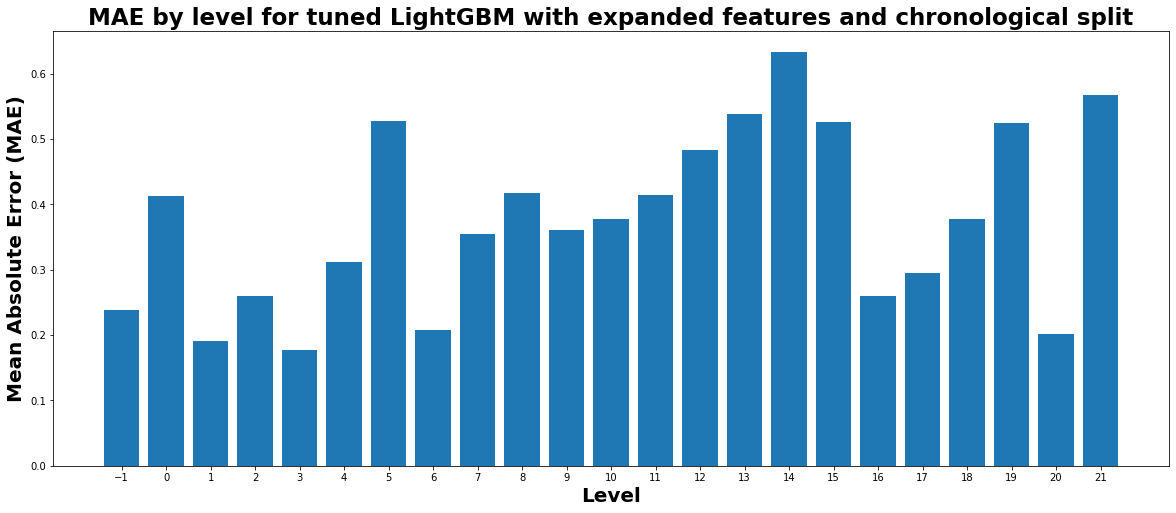

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.47

Round type: 0.5
RMSE: 0.52

Round type: 0.33
RMSE: 0.52

Round type: 0.45
RMSE: 0.51



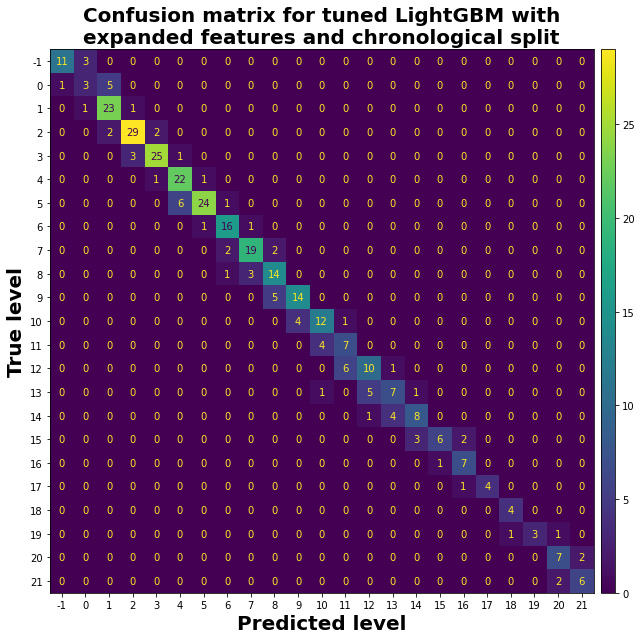

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "default", "expanded", rmse, mae]

###### MAE by level

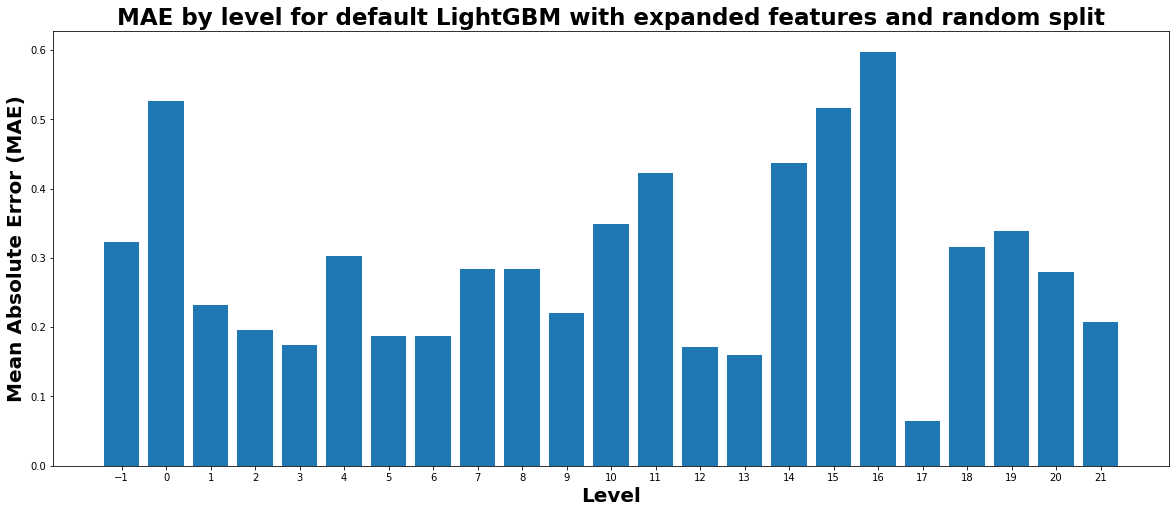

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [35]:
check_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: 0.5
RMSE: 0.39

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.41



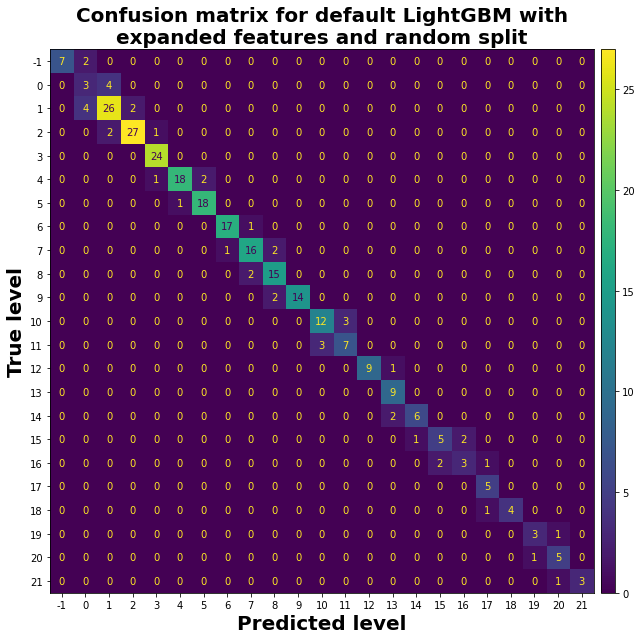

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nexpanded features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 13:23:54,355] A new study created in memory with name: no-name-72373526-bd5a-4b8c-9718-4926521f372b
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.181804 + 0.0415505
[200]	cv_agg's l2: 0.178918 + 0.0376834


feature_fraction, val_score: 0.178086:  14%|######4                                      | 1/7 [00:03<00:20,  3.42s/it]

Early stopping, best iteration is:
[163]	cv_agg's l2: 0.178086 + 0.0380585
[100]	cv_agg's l2: 0.172878 + 0.0366701
[200]	cv_agg's l2: 0.172211 + 0.0329258


feature_fraction, val_score: 0.171837:  29%|############8                                | 2/7 [00:06<00:16,  3.35s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.171837 + 0.0338314
[100]	cv_agg's l2: 0.175717 + 0.0377436
[200]	cv_agg's l2: 0.172587 + 0.0337337


feature_fraction, val_score: 0.171837:  43%|###################2                         | 3/7 [00:10<00:13,  3.46s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.171837 + 0.0338314
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


feature_fraction, val_score: 0.167003:  57%|#########################7                   | 4/7 [00:13<00:10,  3.36s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.172664 + 0.0261471
[200]	cv_agg's l2: 0.168477 + 0.0223003


feature_fraction, val_score: 0.167003:  71%|################################1            | 5/7 [00:16<00:06,  3.28s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.182666 + 0.0393175
[200]	cv_agg's l2: 0.18207 + 0.0365626


feature_fraction, val_score: 0.167003:  86%|######################################5      | 6/7 [00:19<00:03,  3.27s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.194279 + 0.0441132
[200]	cv_agg's l2: 0.19062 + 0.0404321


feature_fraction, val_score: 0.167003: 100%|#############################################| 7/7 [00:23<00:00,  3.31s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517


num_leaves, val_score: 0.167003:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:   5%|##5                                               | 1/20 [00:03<00:57,  3.03s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  10%|#####                                             | 2/20 [00:06<00:55,  3.10s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  15%|#######5                                          | 3/20 [00:09<00:53,  3.17s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  20%|##########                                        | 4/20 [00:12<00:49,  3.10s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.218836 + 0.0614767


num_leaves, val_score: 0.167003:  25%|############5                                     | 5/20 [00:13<00:33,  2.25s/it]

[200]	cv_agg's l2: 0.192778 + 0.0514396
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  30%|###############                                   | 6/20 [00:16<00:36,  2.64s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  35%|#################5                                | 7/20 [00:19<00:36,  2.77s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.183973 + 0.0370053


num_leaves, val_score: 0.167003:  40%|####################                              | 8/20 [00:20<00:26,  2.22s/it]

[200]	cv_agg's l2: 0.177898 + 0.028999
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  45%|######################5                           | 9/20 [00:24<00:28,  2.62s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  50%|########################5                        | 10/20 [00:27<00:27,  2.77s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  55%|##########################9                      | 11/20 [00:30<00:25,  2.89s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  60%|#############################4                   | 12/20 [00:33<00:23,  2.93s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  65%|###############################8                 | 13/20 [00:36<00:20,  3.00s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  70%|##################################3              | 14/20 [00:39<00:17,  3.00s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  75%|####################################7            | 15/20 [00:42<00:15,  3.08s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  80%|#######################################2         | 16/20 [00:46<00:12,  3.15s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  85%|#########################################6       | 17/20 [00:49<00:10,  3.35s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  90%|############################################1    | 18/20 [00:53<00:06,  3.40s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003:  95%|##############################################5  | 19/20 [00:56<00:03,  3.32s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.169475 + 0.0314587
[200]	cv_agg's l2: 0.167424 + 0.0288147


num_leaves, val_score: 0.167003: 100%|#################################################| 20/20 [00:59<00:00,  2.99s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517


bagging, val_score: 0.167003:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.169931 + 0.0313802
[200]	cv_agg's l2: 0.169232 + 0.0288156


bagging, val_score: 0.167003:  10%|#####3                                               | 1/10 [00:03<00:28,  3.16s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.22052 + 0.0272095
[200]	cv_agg's l2: 0.207071 + 0.0171495


bagging, val_score: 0.167003:  20%|##########6                                          | 2/10 [00:04<00:18,  2.28s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.179137 + 0.0366175
[200]	cv_agg's l2: 0.174585 + 0.0336219


bagging, val_score: 0.167003:  30%|###############9                                     | 3/10 [00:07<00:16,  2.33s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517
[100]	cv_agg's l2: 0.235026 + 0.0312675
[200]	cv_agg's l2: 0.222872 + 0.0229557
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.167003 + 0.0293517


bagging, val_score: 0.167003:  40%|#####################2                               | 4/10 [00:08<00:11,  1.99s/it]

[100]	cv_agg's l2: 0.166451 + 0.031483
[200]	cv_agg's l2: 0.16446 + 0.0284226


bagging, val_score: 0.164053:  50%|##########################5                          | 5/10 [00:12<00:12,  2.51s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.164053 + 0.0300278
[100]	cv_agg's l2: 0.166938 + 0.0290424
[200]	cv_agg's l2: 0.166444 + 0.0273624


bagging, val_score: 0.164053:  60%|###############################8                     | 6/10 [00:16<00:12,  3.08s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.164053 + 0.0300278
[100]	cv_agg's l2: 0.166615 + 0.0322533
[200]	cv_agg's l2: 0.165752 + 0.0285839


bagging, val_score: 0.164053:  70%|#####################################                | 7/10 [00:20<00:09,  3.33s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.164053 + 0.0300278
[100]	cv_agg's l2: 0.166595 + 0.031537
[200]	cv_agg's l2: 0.165307 + 0.030259


bagging, val_score: 0.164053:  80%|##########################################4          | 8/10 [00:24<00:07,  3.77s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.164053 + 0.0300278
[100]	cv_agg's l2: 0.164584 + 0.0301584
[200]	cv_agg's l2: 0.162727 + 0.0278787


bagging, val_score: 0.162523:  90%|###############################################7     | 9/10 [00:28<00:03,  3.71s/it]

[300]	cv_agg's l2: 0.164698 + 0.0282568
Early stopping, best iteration is:
[202]	cv_agg's l2: 0.162523 + 0.0277169
[100]	cv_agg's l2: 0.164085 + 0.0310243
[200]	cv_agg's l2: 0.163286 + 0.0277319


bagging, val_score: 0.162170: 100%|####################################################| 10/10 [00:31<00:00,  3.12s/it]


Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539


feature_fraction_stage2, val_score: 0.162170:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164049 + 0.0276944
[200]	cv_agg's l2: 0.163303 + 0.0252622


feature_fraction_stage2, val_score: 0.162170:  17%|######3                               | 1/6 [00:03<00:15,  3.08s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.172686 + 0.0332167
[200]	cv_agg's l2: 0.172278 + 0.0320952


feature_fraction_stage2, val_score: 0.162170:  33%|############6                         | 2/6 [00:06<00:12,  3.09s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.170436 + 0.0237898
[200]	cv_agg's l2: 0.167393 + 0.0211145


feature_fraction_stage2, val_score: 0.162170:  50%|###################                   | 3/6 [00:09<00:09,  3.04s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164049 + 0.0276944
[200]	cv_agg's l2: 0.163303 + 0.0252622


feature_fraction_stage2, val_score: 0.162170:  67%|#########################3            | 4/6 [00:12<00:06,  3.11s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164085 + 0.0310243
[200]	cv_agg's l2: 0.163286 + 0.0277319


feature_fraction_stage2, val_score: 0.162170:  83%|###############################6      | 5/6 [00:15<00:03,  3.22s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164085 + 0.0310243
[200]	cv_agg's l2: 0.163286 + 0.0277319


feature_fraction_stage2, val_score: 0.162170: 100%|######################################| 6/6 [00:19<00:00,  3.31s/it]


Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539


regularization_factors, val_score: 0.162170:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.177492 + 0.0394065


regularization_factors, val_score: 0.162170:   5%|#9                                    | 1/20 [00:01<00:34,  1.82s/it]

[200]	cv_agg's l2: 0.17283 + 0.0368856
Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163411 + 0.0275226


regularization_factors, val_score: 0.162170:  10%|###8                                  | 2/20 [00:04<00:47,  2.61s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163552 + 0.0274731


regularization_factors, val_score: 0.162170:  15%|#####7                                | 3/20 [00:08<00:50,  2.97s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163552 + 0.0274731


regularization_factors, val_score: 0.162170:  20%|#######6                              | 4/20 [00:11<00:47,  2.99s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164762 + 0.030106
[200]	cv_agg's l2: 0.165027 + 0.027704


regularization_factors, val_score: 0.162170:  25%|#########5                            | 5/20 [00:14<00:46,  3.13s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164936 + 0.0300407
[200]	cv_agg's l2: 0.164608 + 0.0280908


regularization_factors, val_score: 0.162170:  30%|###########4                          | 6/20 [00:18<00:44,  3.17s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.17155 + 0.039203
[200]	cv_agg's l2: 0.169329 + 0.0364719


regularization_factors, val_score: 0.162170:  35%|#############3                        | 7/20 [00:21<00:40,  3.14s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.166076 + 0.0304655
[200]	cv_agg's l2: 0.165136 + 0.0270437


regularization_factors, val_score: 0.162170:  40%|###############2                      | 8/20 [00:24<00:38,  3.18s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163411 + 0.0275226


regularization_factors, val_score: 0.162170:  45%|#################1                    | 9/20 [00:27<00:35,  3.18s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163411 + 0.0275226


regularization_factors, val_score: 0.162170:  50%|##################5                  | 10/20 [00:30<00:31,  3.18s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164929 + 0.0308787
[200]	cv_agg's l2: 0.164065 + 0.0273113


regularization_factors, val_score: 0.162170:  55%|####################3                | 11/20 [00:33<00:28,  3.20s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.163709 + 0.0293225
[200]	cv_agg's l2: 0.16352 + 0.0270863


regularization_factors, val_score: 0.162170:  60%|######################2              | 12/20 [00:37<00:25,  3.21s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164929 + 0.0308787
[200]	cv_agg's l2: 0.164065 + 0.0273113


regularization_factors, val_score: 0.162170:  65%|########################             | 13/20 [00:40<00:22,  3.25s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164929 + 0.0308787
[200]	cv_agg's l2: 0.164065 + 0.0273113


regularization_factors, val_score: 0.162170:  70%|#########################9           | 14/20 [00:43<00:19,  3.22s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164763 + 0.030106
[200]	cv_agg's l2: 0.165027 + 0.027704


regularization_factors, val_score: 0.162170:  75%|###########################7         | 15/20 [00:46<00:16,  3.22s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.164537 + 0.0301495
[200]	cv_agg's l2: 0.164731 + 0.028346


regularization_factors, val_score: 0.162170:  80%|#############################6       | 16/20 [00:49<00:12,  3.16s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163514 + 0.0274903


regularization_factors, val_score: 0.162170:  85%|###############################4     | 17/20 [00:53<00:09,  3.18s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.165243 + 0.0306302
[200]	cv_agg's l2: 0.164155 + 0.0274405


regularization_factors, val_score: 0.162170:  90%|#################################3   | 18/20 [00:56<00:06,  3.14s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163514 + 0.0274903


regularization_factors, val_score: 0.162170:  95%|###################################1 | 19/20 [00:59<00:03,  3.20s/it]

Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.1641 + 0.0310096
[200]	cv_agg's l2: 0.163514 + 0.0274903


regularization_factors, val_score: 0.162170: 100%|#####################################| 20/20 [01:02<00:00,  3.14s/it]


Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539


min_data_in_leaf, val_score: 0.162170:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.234224 + 0.0413294


min_data_in_leaf, val_score: 0.162170:  20%|#########                                    | 1/5 [00:01<00:06,  1.63s/it]

[200]	cv_agg's l2: 0.224244 + 0.0383422
Early stopping, best iteration is:
[128]	cv_agg's l2: 0.16217 + 0.0290539
[100]	cv_agg's l2: 0.16174 + 0.0314711
[200]	cv_agg's l2: 0.161 + 0.0306086


min_data_in_leaf, val_score: 0.160822:  40%|##################                           | 2/5 [00:06<00:11,  3.73s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.160822 + 0.0304614
[100]	cv_agg's l2: 0.158083 + 0.0301651
[200]	cv_agg's l2: 0.156839 + 0.0292626
[300]	cv_agg's l2: 0.156655 + 0.028524


min_data_in_leaf, val_score: 0.156469:  60%|###########################                  | 3/5 [00:12<00:09,  4.50s/it]

Early stopping, best iteration is:
[247]	cv_agg's l2: 0.156469 + 0.0288687
[100]	cv_agg's l2: 0.6804 + 0.0574866
[200]	cv_agg's l2: 0.63596 + 0.057915
[300]	cv_agg's l2: 0.617813 + 0.0643492


min_data_in_leaf, val_score: 0.156469:  80%|####################################         | 4/5 [00:13<00:03,  3.34s/it]

Early stopping, best iteration is:
[247]	cv_agg's l2: 0.156469 + 0.0288687
[100]	cv_agg's l2: 0.177679 + 0.0282438
[200]	cv_agg's l2: 0.173632 + 0.0258879
[300]	cv_agg's l2: 0.174024 + 0.0257781


min_data_in_leaf, val_score: 0.156469: 100%|#############################################| 5/5 [00:17<00:00,  3.53s/it]

Early stopping, best iteration is:
[247]	cv_agg's l2: 0.156469 + 0.0288687


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15646868263378544
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.5
    bagging_fraction: 0.9874754318116142
    bagging_freq: 4
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.36
MAE test: 0.24



In [41]:
results.loc[3] = ["random", "Optuna", "expanded", rmse, mae]

###### MAE by level

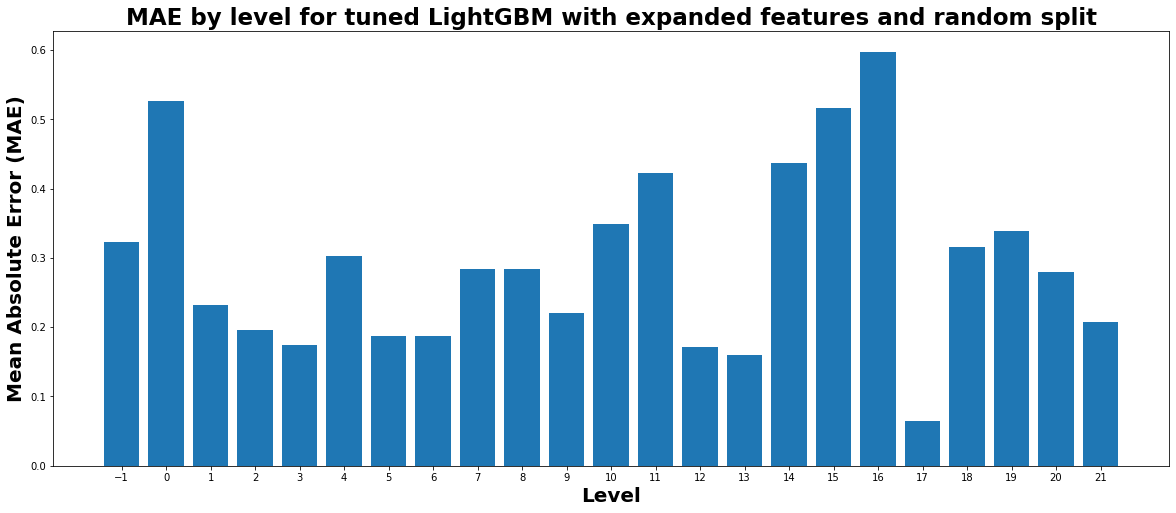

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.21

Round type: 0.5
RMSE: 0.21

Round type: 0.33
RMSE: 0.25

Round type: 0.45
RMSE: 0.21



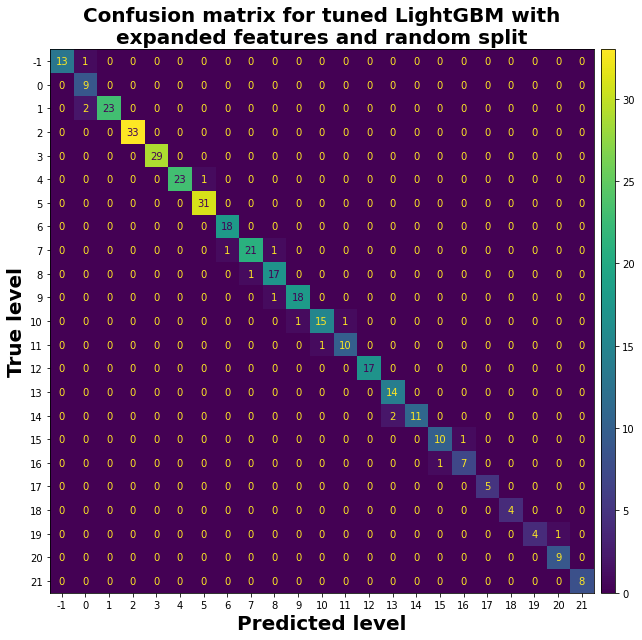

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,expanded,0.510777,0.357209
1,chronological,Optuna,expanded,0.465859,0.336190
2,random,default,expanded,0.384853,0.267273
3,random,Optuna,expanded,0.355773,0.240499


In [46]:
from training.results import plot_summary

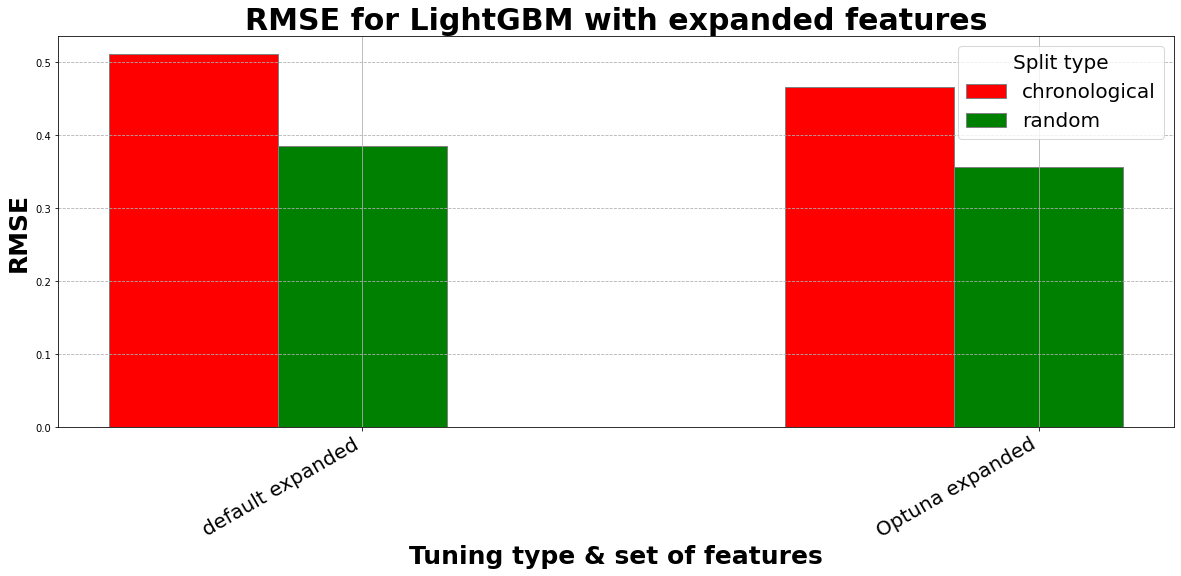

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

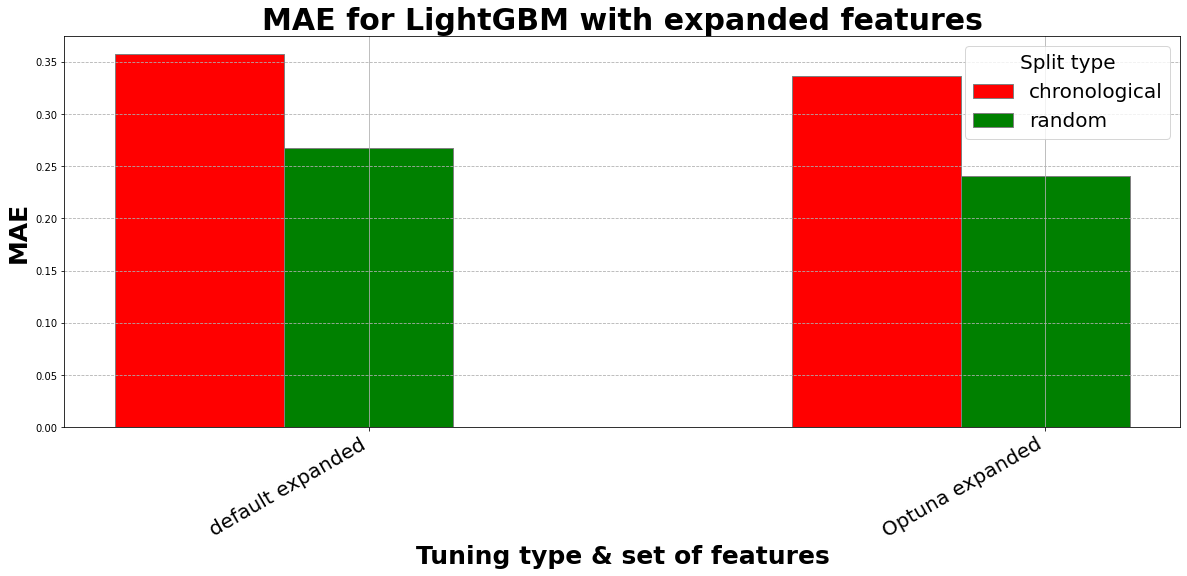

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [49]:
results.to_json("./lightgbm_expanded_results.json", indent=2)